In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from matplotlib.ticker import PercentFormatter
import great_circle_calculator.great_circle_calculator as gcc
import airportsdata
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import set_config


pd.options.display.max_columns = None

%matplotlib inline

np.random.seed(42)

In [71]:
# %pip install category_encoders
# %pip install airportsdata
# %pip install great-circle-calculator

In [2]:
data_train = pd.read_csv("./train.csv")
data_train_ext = pd.read_csv("./train_extended.csv")
data_test = pd.read_csv('test.csv')
train = pd.read_csv('train_engineered_final.csv')
test = pd.read_csv('test_engineered_final.csv')

## Dataset Info

In [3]:
data_train_ext.info

<bound method DataFrame.info of          FlightID  FlightNumber AircraftRegistration  AircraftCapacity  \
0       181142302           221                SPRZK             197.0   
1       178908306          3373                9HQEC             189.0   
2       178886981          2814                9HQCN             189.0   
3       180538798          6893                SPRKP             189.0   
4       178863684          2156                EIDWJ             189.0   
...           ...           ...                  ...               ...   
765231  180266656          9852                EIENM             189.0   
765232  180731656          1237                EIENM             189.0   
765233  181168643          1183                EIEBM             189.0   
765234  181143874           297                EIEVI             189.0   
765235  181252481          3883                EIEVK             189.0   

       AircraftTypeGroup ServiceDescription Carrier AOCDescription  \
0        

In [74]:
## BACK UP DATA SET, DO NOT RUN

#data_train_copy_back_up = data_train
#data_train_copy_back_up

In [75]:
data_train.head()

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,ArrivalScheduled,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,TeledyneRampWeight
0,181142302,221,SPRZK,197.0,Max,Scheduled Flight,FR,Ryanair Sun,EMA-BUD,2022-01-24 09:55:00,2022-01-24 12:30:00,155.0,112.0,6.0,0.0,2.0,43.0,62075.0
1,178908306,3373,9HQEC,189.0,NG,Scheduled Flight,FR,Malta Air,TRN-MLA,2020-03-09 09:00:00,2020-03-09 11:00:00,120.0,18.0,0.0,0.0,0.0,7.0,62002.0
2,178886981,2814,9HQCN,189.0,NG,Scheduled Flight,FR,Malta Air,STN-CGN,2020-01-06 07:35:00,2020-01-06 08:50:00,75.0,126.0,5.0,0.0,0.0,19.0,58029.0
3,180538798,6893,SPRKP,189.0,NG,Scheduled Flight,FR,Ryanair Sun,DTM-KTW,2020-12-11 07:15:00,2020-12-11 08:45:00,90.0,84.0,5.0,0.0,1.0,8.0,56070.0
4,178863684,2156,EIDWJ,189.0,NG,Scheduled Flight,FR,Ryanair DAC,BHX-AGP,2020-02-07 15:20:00,2020-02-07 18:05:00,165.0,175.0,2.0,0.0,0.0,47.0,68315.0


### Histogram plotting cell

In [76]:
## USE THIS IN CASE YOU WANT TO TAKE A LOOK AT SOME DATA.

#histogram_plot = px.histogram(data_train, x = data_train.FlightNumber, y = data_train.Adults)
#histogram_plot.show()

Unique Values count: 3
NG        716946
Airbus     26057
Max        22233
Name: AircraftTypeGroup, dtype: int64


<AxesSubplot:>

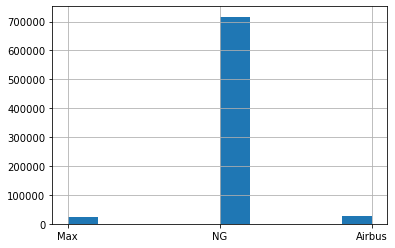

In [77]:
## HISTOGRAM FOR VARIABLE COUNTS DISTRIBUTIONS. 

print("Unique Values count: " + str(data_train.AircraftTypeGroup.nunique()))
print(str(data_train.AircraftTypeGroup.value_counts()))

data_train.AircraftTypeGroup.hist()

### Dataframe information: Non-Null values and datatypes

In [78]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765236 entries, 0 to 765235
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FlightID              765236 non-null  int64  
 1   FlightNumber          765236 non-null  int64  
 2   AircraftRegistration  765236 non-null  object 
 3   AircraftCapacity      765236 non-null  float64
 4   AircraftTypeGroup     765236 non-null  object 
 5   ServiceDescription    765236 non-null  object 
 6   Carrier               765236 non-null  object 
 7   AOCDescription        765236 non-null  object 
 8   ScheduledRoute        765236 non-null  object 
 9   DepartureScheduled    765236 non-null  object 
 10  ArrivalScheduled      765236 non-null  object 
 11  BlockTimeScheduled    765236 non-null  float64
 12  Adults                765236 non-null  float64
 13  Children              765236 non-null  float64
 14  Freight               765236 non-null  float64
 15  

### Correlation Matrix

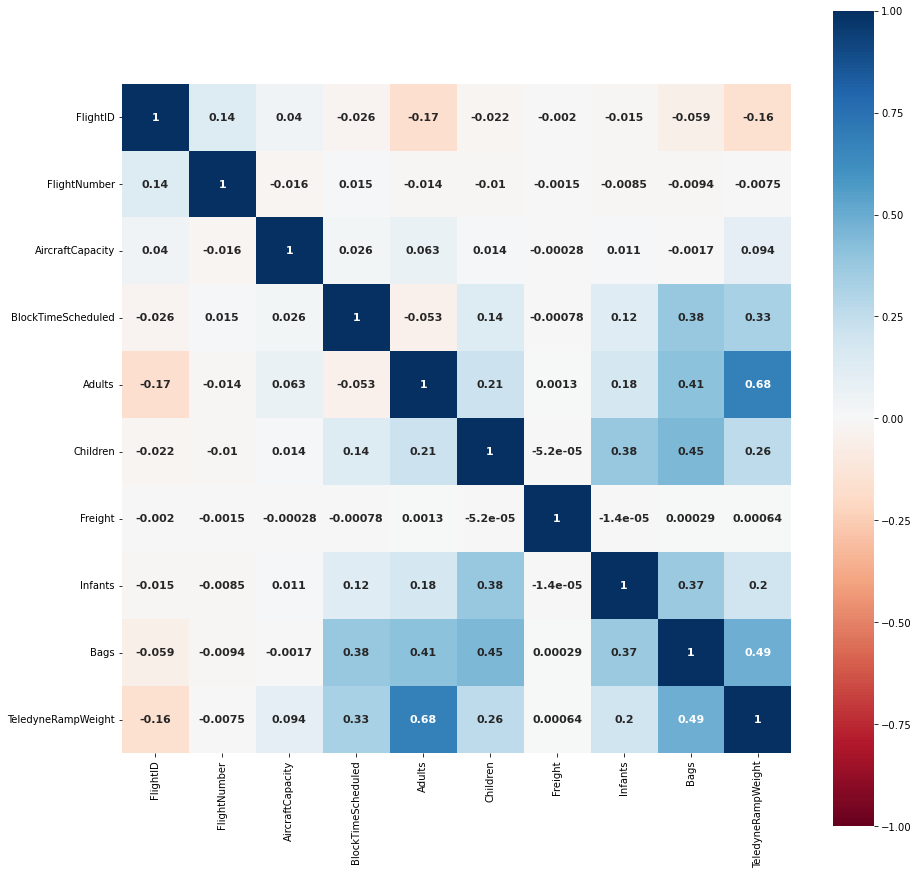

In [79]:
## CORRELATION BETWEEN ALL NUMERICAL VARIABLES: 

corr_mat = data_train.corr()
fig_corr, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr_mat, cmap='RdBu', vmin=-1, vmax=1, annot=True, 
            annot_kws={'fontsize':11, 'fontweight':'bold'},
           square=True);
ax;

## CHANGING DATA TYPES TO CATEGORICAL VARIABLES
### Change Object to Category

In [80]:
## Because we have categorical variables as "objects" we need to apply some function to transform their datatype. 

data_train['FlightID'] = data_train.FlightID.astype('category')
data_train['FlightNumber'] = data_train.FlightNumber.astype('category')
data_train['AircraftRegistration'] = data_train.AircraftRegistration.astype('category')
data_train['AircraftTypeGroup'] = data_train.AircraftTypeGroup.astype('category')
data_train['ServiceDescription'] = data_train.ServiceDescription.astype('category')
data_train['Carrier'] = data_train.Carrier.astype('category')
data_train['AOCDescription'] = data_train.AOCDescription.astype('category')
data_train['ScheduledRoute'] = data_train.ScheduledRoute.astype('category')

data_train.dtypes


FlightID                category
FlightNumber            category
AircraftRegistration    category
AircraftCapacity         float64
AircraftTypeGroup       category
ServiceDescription      category
Carrier                 category
AOCDescription          category
ScheduledRoute          category
DepartureScheduled        object
ArrivalScheduled          object
BlockTimeScheduled       float64
Adults                   float64
Children                 float64
Freight                  float64
Infants                  float64
Bags                     float64
TeledyneRampWeight       float64
dtype: object

In [81]:
data_train.AircraftCapacity.value_counts()

189.0    716856
180.0     26057
197.0     22233
148.0        90
Name: AircraftCapacity, dtype: int64

In [82]:
## Because of categorical features, we need to know if we'll use some encoding method. First step is to check for
## a value count. Knowing the amount of values will give us the total amount of new columns. 

#data_train["AircraftRegistration"].value_counts()
#data_train["AircraftTypeGroup"].value_counts()
#data_train["ServiceDescription"].value_counts()
#data_train["Carrier"].value_counts()
data_train["ScheduledRoute"].value_counts()

DUB-STN    2343
STN-DUB    2289
DUB-LGW    2213
CTA-FCO    2202
FCO-CTA    2165
           ... 
TLS-MAN       1
NAP-SUF       1
CGN-EIN       1
BFS-SXF       1
TPS-BLL       1
Name: ScheduledRoute, Length: 6198, dtype: int64

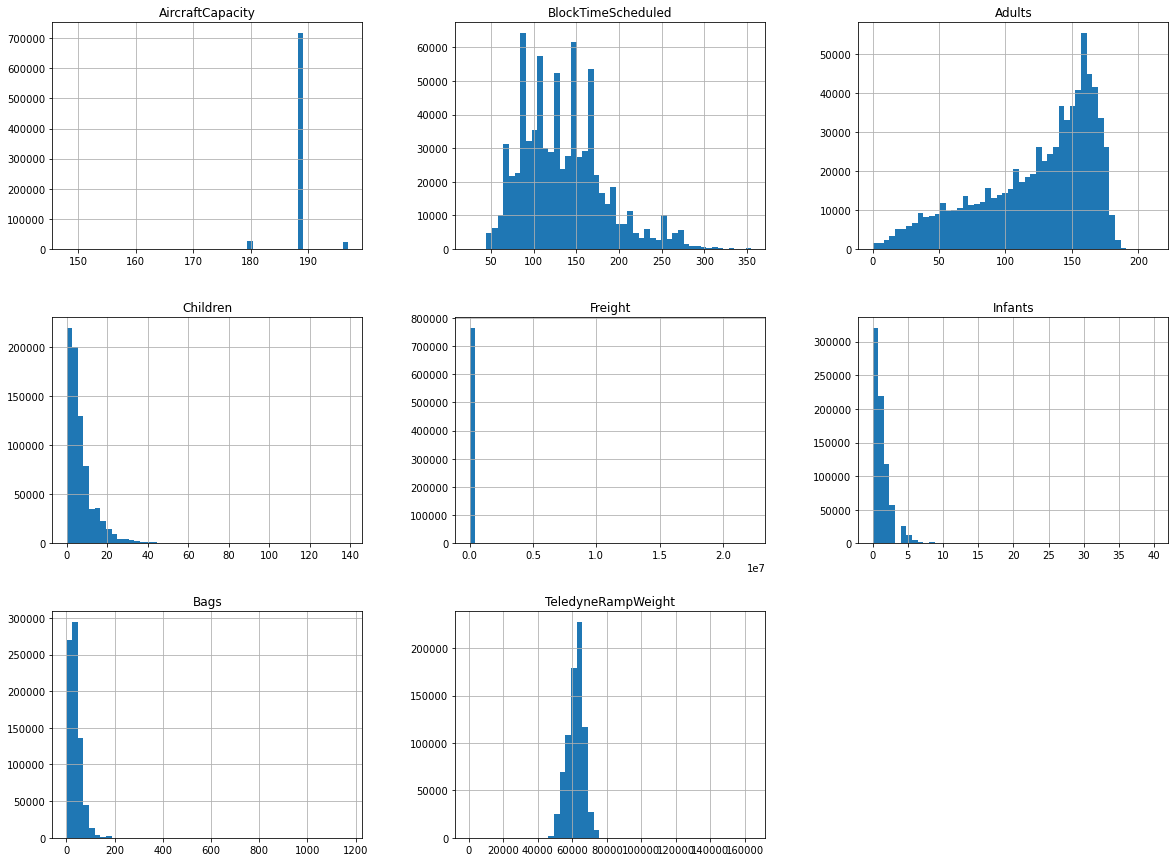

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
data_train.hist(bins=50, figsize=(20,15))
plt.show()

In [84]:
## Let's take a look on how much information our features are giving us by calculating the lienar correlation
## against our Target Variable

corr_matrix = data_train.corr()
corr_matrix["TeledyneRampWeight"].sort_values(ascending=False)

TeledyneRampWeight    1.000000
Adults                0.682161
Bags                  0.486639
BlockTimeScheduled    0.328049
Children              0.263749
Infants               0.201968
AircraftCapacity      0.093802
Freight               0.000640
Name: TeledyneRampWeight, dtype: float64

In [85]:
data_train.head(9)

,FlightID,FlightNumber,AircraftRegistration,AircraftCapacity,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,ScheduledRoute,DepartureScheduled,ArrivalScheduled,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,TeledyneRampWeight
0,181142302,221,SPRZK,197.0,Max,Scheduled Flight,FR,Ryanair Sun,EMA-BUD,2022-01-24 09:55:00,2022-01-24 12:30:00,155.0,112.0,6.0,0.0,2.0,43.0,62075.0
1,178908306,3373,9HQEC,189.0,NG,Scheduled Flight,FR,Malta Air,TRN-MLA,2020-03-09 09:00:00,2020-03-09 11:00:00,120.0,18.0,0.0,0.0,0.0,7.0,62002.0
2,178886981,2814,9HQCN,189.0,NG,Scheduled Flight,FR,Malta Air,STN-CGN,2020-01-06 07:35:00,2020-01-06 08:50:00,75.0,126.0,5.0,0.0,0.0,19.0,58029.0
3,180538798,6893,SPRKP,189.0,NG,Scheduled Flight,FR,Ryanair Sun,DTM-KTW,2020-12-11 07:15:00,2020-12-11 08:45:00,90.0,84.0,5.0,0.0,1.0,8.0,56070.0
4,178863684,2156,EIDWJ,189.0,NG,Scheduled Flight,FR,Ryanair DAC,BHX-AGP,2020-02-07 15:20:00,2020-02-07 18:05:00,165.0,175.0,2.0,0.0,0.0,47.0,68315.0
5,180826676,4731,9HQBG,189.0,NG,Scheduled Flight,FR,Malta Air,BGY-BER,2021-09-17 10:20:00,2021-09-17 12:00:00,100.0,164.0,2.0,0.0,2.0,36.0,63798.0
6,180858684,5919,9HQDH,189.0,NG,Scheduled Flight,FR,Malta Air,PMO-BRI,2021-07-30 17:05:00,2021-07-30 18:25:00,80.0,169.0,2.0,0.0,1.0,53.0,62238.0
7,180091505,6366,EIEBR,189.0,NG,Scheduled Flight,FR,Ryanair DAC,BGY-BCN,2020-09-11 21:50:00,2020-09-11 23:25:00,95.0,71.0,0.0,0.0,0.0,9.0,54492.0
8,180113295,6728,SPRSD,189.0,NG,Scheduled Flight,FR,Ryanair Sun,CRL-KRK,2020-08-04 06:55:00,2020-08-04 08:50:00,115.0,129.0,12.0,0.0,6.0,36.0,60859.0


### Unique values count

In [86]:
print("Unique Values count: " + str(data_train.ScheduledRoute.nunique()))
data_train.ScheduledRoute.value_counts()

Unique Values count: 6198


DUB-STN    2343
STN-DUB    2289
DUB-LGW    2213
CTA-FCO    2202
FCO-CTA    2165
           ... 
TLS-MAN       1
NAP-SUF       1
CGN-EIN       1
BFS-SXF       1
TPS-BLL       1
Name: ScheduledRoute, Length: 6198, dtype: int64

In [87]:
data_train.ScheduledRoute.value_counts()

DUB-STN    2343
STN-DUB    2289
DUB-LGW    2213
CTA-FCO    2202
FCO-CTA    2165
           ... 
TLS-MAN       1
NAP-SUF       1
CGN-EIN       1
BFS-SXF       1
TPS-BLL       1
Name: ScheduledRoute, Length: 6198, dtype: int64

#### Preparing our data for processing. 

In [88]:
data_train.AircraftRegistration.describe()

count     765236
unique       693
top        9HQAC
freq        2209
Name: AircraftRegistration, dtype: object

In [89]:
data_train.ScheduledRoute.describe()

count      765236
unique       6198
top       DUB-STN
freq         2343
Name: ScheduledRoute, dtype: object

In [90]:
data_train.AircraftTypeGroup.describe()

count     765236
unique         3
top           NG
freq      716946
Name: AircraftTypeGroup, dtype: object

## Feature Engineering

In [4]:
### Computing Payload 
def Payload(dataframe):
    ## Assumptions made on weight based on slides provided and statistics
    avg_weight_adult = 84
    avg_weight_children = 35
    avg_weight_infant = 3.5
    avg_weight_bag = 15

    ## transforming Given columns to incorporate weight of each of them
    dataframe['Adults'] = dataframe.Adults*avg_weight_adult
    dataframe['Children'] = dataframe.Children*avg_weight_children
    dataframe['Infants'] = dataframe.Infants*avg_weight_infant
    dataframe['Bags'] = dataframe.Bags*avg_weight_bag
    
    ## PAX: Passenger Weight
    PAX = dataframe.Adults+dataframe.Children+dataframe.Infants
    
    ## TP: Total Payload --> PAX + Freight Weight + Bags Weight
    dataframe['TP'] = dataframe.Freight + dataframe.Bags + PAX
    
    dataframe.drop(['Adults','Children','Infants','Bags','Freight'], axis=1, inplace=True)
    return dataframe;

In [5]:
data_train_ext=Payload(data_train_ext)
data_test=Payload(data_test)

## Intermediate Model to Predict Burnoff onto the Test Set

## Intermediate Model to Predict Fuel onto the Test Set


#### The engineered Train and Test set both include Fuel And Burnoff calculated on the intermediate Steps

## Route Distance Computation

In [93]:
## Function to compute distances between origin and destination airports
def route_dist(dataframe, x):
    ## loading airport data 
    airports = airportsdata.load('name')
    airports = pd.DataFrame(airports)
    airports = airports.T
    
    if x=='A':
        a=dataframe["ActualRoute"].str.extract(r'(?P<Origin>\w+)[-](?P<Destination>\w+)')
    elif x=='S':
        a=dataframe["ScheduledRoute"].str.extract(r'(?P<Origin>\w+)[-](?P<Destination>\w+)')

    origin = list(np.unique(a.Origin))
    destination = list(np.unique(a.Destination))
    df_or =pd.DataFrame(a['Origin'])
    df_dest=pd.DataFrame(a['Destination'])
    matched_o_list=[]
    for i in origin:
        if i in airports.index:
            matched_o_list.append(i)
    
    ## List of Airports from our dataset that match airports from the Airports Library
    matched_df = airports.loc[matched_o_list,:]  
    
    ## Missing latitude and Longitude from Airports Dataset
    missing_lat={'SXF':52.3733,'SZY':53.4879 ,'LYS':45.7234,'RVN':40.1492,'IEV':50.4120 , 'BEG':44.8196 , 'KEF':63.9815 , 'MPL':43.5796,'LGG':50.6412 ,'LIN':45.4533,'NRK':58.5834,'GVA':46.2370, 'SPU':43.5367 , 'LLA':33.9416 ,'PRN':42.5746 , 'CDG':49.0081 , 'SPC':28.6259 }
    missing_long={'SXF':13.5064,'SZY':20.9465,'LYS':5.0888,'RVN':44.3989 ,'IEV':30.4433 , 'BEG':20.2901 , 'KEF':22.6282 , 'MPL':3.9652,'LGG':5.4479 ,'LIN':9.2763 ,'NRK': 16.2339,'GVA':6.1091, 'SPU':16.2990 , 'LLA':118.4085 ,'PRN':21.0295 , 'CDG':2.5509 , 'SPC':17.7551 }  

    ## Splitting lattitude and longitude from our matched dataframe and transforming to dictionary to then Map to The Origin and Dest
    lat=matched_df['lat'].to_dict()
    lon=matched_df['lon'].to_dict()
    
    ### Mapping Lattitude and Longitudes for Origin and Destination
    df_or['lato']=df_or.Origin.map(lat)
    df_or['lono']=df_or.Origin.map(lon)
    df_dest['latd']=df_dest.Destination.map(lat)
    df_dest['lond']=df_dest.Destination.map(lon)
    
    
    ### Mapping Missing values for Lattitude and Longitude
    df_or['lato']=df_or['Origin'].map(missing_lat).fillna(df_or['lato'])
    df_or['lono']=df_or['Origin'].map(missing_long).fillna(df_or['lono'])
    df_dest['latd']=df_dest['Destination'].map(missing_lat).fillna(df_dest['latd'])
    df_dest['lond']=df_dest['Destination'].map(missing_long).fillna(df_dest['lond'])
    
    ## For loop that appends computed value of distance between origin airport and destination airport 
    route_dist=[]
    for i in range(0,df_dest.shape[0]):
        p1 = (round(df_or.lono[i],4),round(df_or.lato[i],4))
        p2 = (round(df_dest.lond[i],4),round(df_dest.latd[i],4))
        route_dist.append(gcc.distance_between_points(p1, p2, unit='kilometers', haversine=True))
        
    ## Return Actual Route Distance(A) or Scheduled Route Distance(S) based on need of the user
    if x=='A':
        dataframe['ActualRoute_dist']=pd.Series(route_dist)
        return dataframe['ActualRoute_dist'];
    
    if x=='S':
        dataframe['ScheduledRoute_dist']=pd.Series(route_dist)
        return dataframe['ScheduledRoute_dist'];
    
## Computing Distances for Scheduled and Actual Distances
data_train_ext['ScheduledRoute_dist']=route_dist(data_train_ext, x='S')
data_train_ext['ActualRoute_dist']=route_dist(data_train_ext, x='A')
data_test['ScheduledRoute_dist']=route_dist(data_test, x='S')

## Payload Outlier handling 

#### Not included in Final Model

In [94]:
## Max Payload: in kg accoring to each aircraft specification
MAX_payload_max =20882 
NG_payload_max = 20540
Airbus_payload_max=16600

## If we find a payload higher than the maximum payload based on each aircraft type
## we replaced the value with the maximum payload.
def Payload_outlier_transform(dataframe):
    Payload_transform=[]
    for i,j in zip(dataframe.AircraftTypeGroup, dataframe.TP):
        ## Max
        if i=='Max'and j<=MAX_payload_max:
            Payload_transform.append(j)
        elif i=='Max'and j>MAX_payload_max:
            Payload_transform.append(MAX_payload_max)
        ## NG
        if i=='NG'and j<=NG_payload_max:
            Payload_transform.append(j)
        elif i=='NG'and j>NG_payload_max:
            Payload_transform.append(NG_payload_max) 
        ## Airbus
        if i=='Airbus'and j<=Airbus_payload_max:
            Payload_transform.append(j)
        elif i=='Airbus'and j>Airbus_payload_max:
            Payload_transform.append(Airbus_payload_max) 

    ## Transforming our original variable Payload with the transformed payload values
    dataframe['TP']=pd.Series(Payload_transform)
    return dataframe;

data_train_ext = Payload_outlier_transform(data_train_ext)
data_test = Payload_outlier_transform(data_test)

## Fuel Outlier handling 

#### Not included in Final Model

In [95]:

## Replacing outliers with the maximum fuel capacity of the aircraft
def fuel_outlier_transform(dataframe):
    MAX_fuel_max =82191-65952 
    NG_fuel_max = 79000-61690
    Airbus_fuel_max=78000-62500

    Fuel_transform=[]
    for i,j in zip(dataframe.AircraftTypeGroup, dataframe.Fuel):
        ## Max
        if i=='Max'and j<=MAX_fuel_max:
            Fuel_transform.append(j)
        elif i=='Max'and j>MAX_fuel_max:
            Fuel_transform.append(MAX_fuel_max)
        ## NG
        if i=='NG'and j<=NG_fuel_max:
            Fuel_transform.append(j)
        elif i=='NG'and j>NG_fuel_max:
            Fuel_transform.append(NG_fuel_max) 
        ## Airbus
        if i=='Airbus'and j<=Airbus_fuel_max:
            Fuel_transform.append(j)
        elif i=='Airbus'and j>Airbus_fuel_max:
            Fuel_transform.append(Airbus_fuel_max) 


    dataframe['Fuel'] =pd.Series(Fuel_transform)
    dataframe.drop('Fuel_transform', axis=1, inplace=True)
    return dataframe;



## Extraction of Time and Day 

In [96]:
## Function to compute day shift based on hour range
def time(dataframe):
    
    ## Transforming columns into datetime format
    dataframe['DepartureScheduled'] = pd.to_datetime(dataframe['DepartureScheduled']) 
    dataframe['Departure_Time'] = [d.time() for d in dataframe['DepartureScheduled']]
    dataframe['Departure_date'] = [d.date() for d in dataframe['DepartureScheduled']]
    dataframe['DepartureScheduled'] = dataframe['DepartureScheduled'].astype('datetime64[ns]')
    dataframe['Time_in_Hr']= dataframe.DepartureScheduled.dt.hour
    
    ## Extrcating month, day of week, year from departure scheduled
    dataframe['month'] = pd.DatetimeIndex(dataframe['DepartureScheduled']).month
    dataframe['dayofweek'] = pd.DatetimeIndex(dataframe['DepartureScheduled']).dayofweek
    dataframe['year'] = pd.DatetimeIndex(dataframe['DepartureScheduled']).year
    dataframe["dayofweek"]=dataframe["dayofweek"].astype("object")
    dataframe["month"]=dataframe["month"].astype("object")
    dataframe["year"]=dataframe["year"].astype("object")

    # function to calculate shifts based on hour range
    def to_shift(hour):
        if hour < 6 or hour >= 21:
            return "Night"
        elif hour >= 6 and hour < 9:
            return "Early Morning"
        elif hour >= 9 and hour < 12:
            return "Morning"
        elif hour >= 12 and hour < 15:
            return "Midday"
        elif hour >= 15 and hour < 18:
            return "Evening"
        elif hour >= 18 and hour < 21:
            return "Late Evening"
        
    dataframe['shift'] = dataframe['Time_in_Hr'].apply(to_shift)
    dataframe.drop(['Time_in_Hr'], axis=1, inplace=True)
    return dataframe;

data_train = time(data_train)

In [97]:
def drop_columns(dataframe):
    dataframe.drop('Carrier',axis=1, inplace =True)
    dataframe.drop('FlightID',axis=1, inplace =True)
    dataframe.drop('DepartureScheduled',axis=1, inplace =True)
    dataframe.drop('ArrivalScheduled',axis=1, inplace =True)
    dataframe.drop('Departure_Time',axis=1, inplace =True)
    dataframe.drop('FlightNumber',axis=1, inplace =True)
    
    return dataframe;

data_train = drop_columns(data_train)

In [98]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765236 entries, 0 to 765235
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   AircraftRegistration  765236 non-null  category
 1   AircraftCapacity      765236 non-null  float64 
 2   AircraftTypeGroup     765236 non-null  category
 3   ServiceDescription    765236 non-null  category
 4   AOCDescription        765236 non-null  category
 5   ScheduledRoute        765236 non-null  category
 6   BlockTimeScheduled    765236 non-null  float64 
 7   Adults                765236 non-null  float64 
 8   Children              765236 non-null  float64 
 9   Freight               765236 non-null  float64 
 10  Infants               765236 non-null  float64 
 11  Bags                  765236 non-null  float64 
 12  TeledyneRampWeight    765236 non-null  float64 
 13  Departure_date        765236 non-null  object  
 14  month                 765236 non-nul

## Target Variable TeledyneRampWeight Outlier Handling


In [ ]:

mean=np.mean(train.TeledyneRampWeight)
sd = np.std(train.TeledyneRampWeight)
min_outliers = train[train.TeledyneRampWeight<=mean-2*sd].index
max_outliers = train[train.TeledyneRampWeight>=mean+2*sd].index


train.drop(min_outliers, inplace=True)
train.drop(max_outliers, inplace=True)


## Final Model

In [102]:
### columns for one hot encoding
ohe_cats=['ServiceDescription','AircraftCapacity','AircraftTypeGroup','AOCDescription','dayofweek','year','shift']
### columns for target encoding
target_encoding_cats=['AircraftRegistration','ScheduledRoute','month']

## test set declaration
X_test = test

## Create X, all columns except target
X = train.drop('TeledyneRampWeight',axis=1)

# Create y, only the target column
y = train["TeledyneRampWeight"]


# this is defining the column transformers
transformer = ColumnTransformer(transformers=[
    ('TAR',TargetEncoder(),target_encoding_cats),
    ('OHE',OneHotEncoder(sparse=False,drop='first'),ohe_cats)],
     remainder='passthrough')

# One again run this if testing needs to be done on training
transformer.fit(X,y)
X_train_transformed = transformer.transform(X)
X_test_transformed = transformer.transform(X_test)



## declaring xgb regressor after hyperparameter tuning                
gbm = xgb.XGBRegressor(
    base_score=0.2, 
    booster='gbtree', 
    callbacks=None,
    colsample_bylevel=1, 
    colsample_bynode=1, 
    colsample_bytree=1,
    early_stopping_rounds=None, 
    enable_categorical=False,
    eval_metric=None, 
    gamma=0, 
    gpu_id=-1, 
    grow_policy='depthwise',
    importance_type=None, 
    interaction_constraints='',
    learning_rate=0.1, ## Default Value = 0.300000012
    max_bin=256, 
    max_cat_to_onehot=4,
    max_delta_step=0, 
    max_depth=9, 
    max_leaves=0, 
    min_child_weight=0.5,
    monotone_constraints='()', 
    n_estimators=110, 
    n_jobs=0,
    num_parallel_tree=1, 
    predictor='auto', 
    random_state=42, 
    reg_alpha=0,
    reg_lambda=1
)

gbm.fit(X_train_transformed,y)

## XGBoost predictions: TeledyneRampWeight
test['TeledyneRampWeight'] = gbm.predict(X_test_transformed)
'''
## Exporting predictions into a csv file
model_1_pred= test['TeledyneRampWeight']
test_id=pd.Series(data_test.FlightID)
result = pd.DataFrame({'FlightID':test_id, 'TeledyneRampWeight':model_1_pred})
result.set_index('FlightID', inplace = True)
result.to_csv('predictions_xgb_final_datathon.csv')#,sep=',', float_format='%.0f')
'''

C:\Users\uSUARIO\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning:

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327

C:\Users\uSUARIO\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning:

Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327



## Corrector Model, to predict the errors of our XgBoost Model & Final Submission

In [ ]:
train['train_pred']= gbm.predict(X_train_transformed)

train['xgb_error']=train['TeledyneRampWeight']-train['train_pred']
from sklearn.linear_model import LinearRegression # class
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
time_route_vars = ['dayofweek','month', 'shift','ScheduledRoute']
linear = LinearRegression() # creation of instance of that class

#to_scale=['Burnoff']
ohe_cats=['dayofweek','month','shift']
target_encoding_cats=['ScheduledRoute']

### Defining sets

X = train.loc[:,time_route_vars]
y = train['xgb_error']

X_test = test.loc[:,time_route_vars]
# this is defining the column transformers
transformer = ColumnTransformer(transformers=[
         ('OHE',OneHotEncoder(sparse=False,drop='first'),ohe_cats),#('scaler',StandardScaler(),to_scale),
          ('TAR',TargetEncoder(),target_encoding_cats)],remainder='passthrough')

# One again run this if testing needs to be done on training
transformer.fit(X,y)
X_train_transformed = transformer.transform(X)
X_test_transformed = transformer.transform(X_test)

corrector_model = linear.fit(X_train_transformed,y)
test['xgb_error'] = linear.predict(X_test_transformed)

model_1_pred= test['TeledyneRampWeight']+test['xgb_error']
test_id=pd.Series(data_test.FlightID)
result = pd.DataFrame({'FlightID':test_id, 'TeledyneRampWeight':model_1_pred})
result.set_index('FlightID', inplace = True)
result.to_csv('predictions_xgb_final_datathon.csv')#,sep=',', float_format='%.0f')